## Features mas importantes para denunciante target genero:
1. Number of numbers
2. Number of capital letters
3. Ratio of adverbs
4. Ratio of pronouns
5. Ratio of prepositions
6. Number of punctuations
7. Ratio of propositions
8. Number of characters
9. Average length
10. Number of words with length greater than 6

In [117]:
import re
import sys
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from nltk.tokenize import word_tokenize
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from emoji import emoji_count
import statistics as stat
import nltk
from nltk.corpus import cess_esp
import os
import json
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from matplotlib import pyplot
import math
from string import digits
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu,kruskal
from scikit_posthocs import posthoc_dunn
from wordcloud import WordCloud

In [2]:
URLS_RE = re.compile(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*')

LISTING_RE = re.compile(r'^(|[a-z]?|[0-9]{0,3})(\-|\.)+( |\n)')

def remove_urls(text):
    return URLS_RE.sub('', text)

def replace_multi_whitespaces(line):
    return ' '.join(line.split())

def remove_listing(line):
    return LISTING_RE.sub('', line)

def remove_punctuation(text):
    text = text.replace('!','')
    text = text.replace('"','')
    return text.translate(str.maketrans('','',string.punctuation))

def quitar_guiones(text):
    aux = text.split('--')
    aux2 = []
    for w in aux:
        if len(w)>0:
            text = replace_multi_whitespaces(w)
            aux2.append(text)
    return '\n'.join(aux2)

def quitar_tags(text):
    tags = 'LOC|NUM|TIEM|PER'
    regex = re.compile(tags,re.S)
    res = regex.sub('', text)
    return res.replace('<','')

def remove_stopwords(text,stop_words):
    words = text.split(' ')
    not_stop_words = []
    for word in words:
        if word not in stop_words:
            not_stop_words.append(word)
    return ' '.join(not_stop_words)
      

def clean_text(text,stop_words):	

    low = text.lower()
    rem_u = remove_urls(low)
    rem_l = remove_listing(rem_u)
    rem_t = quitar_tags(rem_l)
    rem_w = replace_multi_whitespaces(rem_t)
    rem_p = remove_punctuation(rem_w)
    rem_s = remove_stopwords(rem_p,stop_words)
    text_enc = rem_s.encode('ascii', 'ignore')

    return text_enc.decode()

def tagger():
    oraciones = cess_esp.tagged_sents()
    return nltk.UnigramTagger(oraciones)

def load_sentiment_analysis():
    sent_analysis_data = pd.read_csv('../../Spanish-NRC-EmoLex.txt',sep='\t')
    spanish_dict = list(sent_analysis_data['Spanish Word'])
    negative_cols = ['negative','fear','anger','disgust','sadness']
    positive_cols = ['positive','joy','trust']

    negative_words = []
    for col in negative_cols:
        i = 0
        for val in sent_analysis_data[col]:
            if val == 1:
                negative_words.append(spanish_dict[i])
            i += 1

    positive_words = []
    for col in positive_cols:
        i = 0
        for val in sent_analysis_data[col]:
            if val == 1:
                positive_words.append(spanish_dict[i])
            i += 1

    return set(positive_words),set(negative_words)

def sent_analysis(words,positive_words,negative_words):

    intersection_neg = list(negative_words & set(words))
    intersection_pos = list(positive_words & set(words))

    return len(intersection_pos),len(intersection_neg)

# returns a list of words that occur exactly 'num' times or None if no coincidence
def num_occurences(lista,num):
    aux_dict = {}
    for item in lista:
        if item in aux_dict.keys():
            aux_dict[item] += 1
        else:
            aux_dict[item] = 1

    try:
        idx = list(aux_dict.values()).index(num)
        words = list(aux_dict.keys())[idx]
        return len(words)
    except:
        return 0
    

def get_edad(fn,file):
    # fn del denunciante
    if '/' not in fn:
        if len(fn) != 8:
            return -1
        year = fn[:4]
        month = fn[4:6]
        day = fn[6:]
    else:
        aux = fn.split('/')
        if len(aux) != 3:
            return -1
        
        day = aux[0]
        month = aux[1]
        year = aux[-1]
    
    try:
        fecha = datetime.date(int(year),int(month),int(day))
    except:
        print(file)
    diff = relativedelta(datetime.date.today(),fecha).years

    if diff < 25:
        edad = '18-24'
    elif diff < 35:
        edad = '25-34'
    elif diff < 45:
        edad = '35-44'
    elif diff < 55:
        edad = '45-54'
    else:
        edad = '+55'
    return edad
        
def get_region(provincia):
    
    df = pd.read_excel('../Tabla Provincias.xls')
    ccaa = list(df.loc[df['Nombre Provincia'].str.contains(provincia.upper())]['Nombre CCAA'])
    if len(ccaa) == 0:
        return provincia
    
    return ccaa[0]

def data_scaler(data):
    scaler = StandardScaler()
    x = data.values
    cols = data.columns
    x_scaled = scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled,columns=cols)
    return df

def save_results(y_test,y_pred,average,tunning=False,params=None):

    acc = accuracy_score(y_test,y_pred)
    prec = precision_score(y_test,y_pred,average=average)
    rec = recall_score(y_test,y_pred,average=average)
    f1 = f1_score(y_test,y_pred,average=average)

    if tunning:
        sent = f'\t\t\t* With tunning: {params}\n'
    else:
        sent = f'\t\t\t* Without tunning:\n'

    with open('debiasing_results.txt','a') as f:
        f.write(sent)
        f.write(f'\t\t\t\t-> Accuracy: {acc}\n')
        f.write(f'\t\t\t\t-> Precision: {prec}\n')
        f.write(f'\t\t\t\t-> Recall: {rec}\n')
        f.write(f'\t\t\t\t-> F1-score: {f1}\n')

In [3]:
stop_words_df = pd.read_csv('../../spanish-stop-words.txt',header=None)
stop_words = list(stop_words_df[0]) + ['q','ma']

files = os.listdir('../Atestados')
files.remove('.DS_Store')

In [4]:
df = pd.DataFrame()

In [5]:
positive_words,negative_words = load_sentiment_analysis()

## Denunciante DF

In [6]:
paises = pd.read_excel('../../paises_estandar.xls')
paises['Continente'] = [s.translate(str.maketrans('', '', digits)) for s in paises['Continente']]
paises.head()

,Continente,Código,País o territorio
0,UNIÓN EUROPEA,102,AUSTRIA
1,UNIÓN EUROPEA,103,BELGICA
2,UNIÓN EUROPEA,104,BULGARIA
3,UNIÓN EUROPEA,106,CHIPRE
4,UNIÓN EUROPEA,107,DINAMARCA


In [7]:
from geopy.geocoders import Nominatim 
from string import digits
geolocator = Nominatim(user_agent="preprocessing")

denunciante_df = pd.DataFrame()  

list_genero = []
list_region = []
list_edad = [] 

files_with_errors = []
paises_hispanohablantes = ['Argentina', 'Bolivia', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Ecuador', 'El Salvador', 'Guatemala', 'Guinea Ecuatorial', 'Honduras', 'México', 'Nicaragua', 'Panamá', 'Uruguay', 'Perú', 'Puerto Rico', 'República Dominicana', 'Uruguay', 'Venezuela']

i = 0
for file in files:
    with open(f'../Atestados/{file}') as f:
        _dict = json.load(f)
        # denunciante
        denunciante = _dict['denunciante']
        provincia = denunciante['provincia'].title()
        genero = denunciante['sexo']
        fn = denunciante['fn']
        # obtener comunidad autonoma
        try:
            location = geolocator.geocode(provincia,language='es').raw['display_name']
            location = location.translate(str.maketrans('', '', digits))
            location_aux = [l for l in location.split(', ') if len(l)>0]

            if len(location_aux) == 1:
                if location_aux[-1] == 'España':
                    region = 'Comunidad de Madrid'
                elif location_aux[-1] in paises_hispanohablantes:
                    region = 'LATINOS'
                else:
                    region = paises.loc[paises[' País o  territorio'] == location_aux[-1].upper()]['Continente'].item()

            else:
                ccaa = location_aux[-2]
                pais = location_aux[-1]
                if pais != 'España':
                    if pais in paises_hispanohablantes:
                        region = 'LATINOS'
                    else:
                        region = paises.loc[paises[' País o  territorio'] == location_aux[-1].upper()]['Continente'].item()
                else:
                    region = ccaa

            edad = get_edad(fn,file)
            if edad == -1:
                files_with_errors.append(file)
            else:
                list_genero.append(genero)
                list_edad.append(edad)
                list_region.append(region)
        except:
            files_with_errors.append(file)

    i += 1
    print(f'{i} de {len(files)}')

denunciante_df['gender'] = list_genero
denunciante_df['age'] = list_edad
denunciante_df['region'] = list_region

1 de 3898
2 de 3898
3 de 3898
4 de 3898
5 de 3898
6 de 3898
7 de 3898
8 de 3898
9 de 3898
10 de 3898
11 de 3898
12 de 3898
13 de 3898
14 de 3898
15 de 3898
16 de 3898
17 de 3898
18 de 3898
19 de 3898
20 de 3898
21 de 3898
22 de 3898
23 de 3898
24 de 3898
25 de 3898
26 de 3898
27 de 3898
28 de 3898
29 de 3898
30 de 3898
31 de 3898
32 de 3898
33 de 3898
34 de 3898
35 de 3898
36 de 3898
37 de 3898
38 de 3898
39 de 3898
40 de 3898
41 de 3898
42 de 3898
43 de 3898
44 de 3898
45 de 3898
46 de 3898
47 de 3898
48 de 3898
49 de 3898
50 de 3898
51 de 3898
52 de 3898
53 de 3898
54 de 3898
55 de 3898
56 de 3898
57 de 3898
58 de 3898
59 de 3898
60 de 3898
61 de 3898
62 de 3898
63 de 3898
64 de 3898
65 de 3898
66 de 3898
67 de 3898
68 de 3898
69 de 3898
70 de 3898
71 de 3898
72 de 3898
73 de 3898
74 de 3898
75 de 3898
76 de 3898
77 de 3898
78 de 3898
79 de 3898
80 de 3898
81 de 3898
82 de 3898
83 de 3898
84 de 3898
85 de 3898
86 de 3898
87 de 3898
88 de 3898
89 de 3898
90 de 3898
91 de 3898
92 de 38

## Policia DF

In [52]:
policia_df = pd.DataFrame()  

list_genero = []
list_region = []
list_edad = [] 
list_file = []

for file in files:
    with open(f'../Atestados/{file}') as f:
        _dict = json.load(f)
        # policia
        policia = _dict['cp']
        provincia = policia['provincia'].title()
        genero = policia['sexo']
        fn = policia['fn']
        region = get_region(provincia)
        edad = get_edad(fn,file)

        list_genero.append(genero)
        list_edad.append(edad)
        list_region.append(region)
        list_file.append(file)

policia_df['gender'] = list_genero
policia_df['age'] = list_edad
policia_df['region'] = list_region
policia_df['file'] = list_file

In [15]:
policia_df.head()

,gender,age,region
0,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA
1,H,35-44,COMUNIDAD VALENCIANA
2,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA
3,H,25-34,COMUNIDAD VALENCIANA
4,H,35-44,PRINCIPADO DE ASTURIAS


In [8]:
denunciante_df.head()

,gender,age,region
0,H,25-34,Andalucía
1,M,+55,Castilla-La Mancha
2,M,25-34,LATINOS
3,M,+55,ASIA
4,M,+55,Comunidad Valenciana


In [8]:
# remove files with errors
files = [file for file in files if file not in files_with_errors]

In [53]:
# load data for character based features analysis
def df_character_based():
    data = pd.DataFrame()    
    punctuation_list = list(string.punctuation)

    num_char = []
    num_capital = []
    num_punctuation = []

    for file in files:
        with open(f'../Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)
            num_char.append(len(cleaned_text))
            num_capital.append(sum(1 for c in cleaned_text if c.isupper()))
            num_punctuation.append(sum(1 for c in cleaned_text if c in punctuation_list))
    
    data['characters'] = num_char
    data['capital_letters'] = num_capital
    data['punctuations'] = num_punctuation

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)

In [10]:
df_char = df_character_based()
df_char.head()

,gender,age,region,characters,capital_letters,punctuations
0,H,25-34,Andalucía,-1.059725,-0.662752,-0.927288
1,M,+55,Castilla-La Mancha,-0.291598,-0.621088,-0.244614
2,M,25-34,LATINOS,-0.553765,-0.343324,-0.634714
3,M,+55,ASIA,0.962888,0.934391,2.242269
4,M,+55,Comunidad Valenciana,3.575990,2.517646,3.705141


In [11]:
gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_char['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_char['region'].unique():
    region_dict[region] = i
    i += 1

df_char['gender'] = df_char['gender'].map(gender_dict)
df_char['age'] = df_char['age'].map(age_dict)
df_char['region'] = df_char['region'].map(region_dict)
df_char.head()

,gender,age,region,characters,capital_letters,punctuations
0,1,0,0,-1.059725,-0.662752,-0.927288
1,0,1,1,-0.291598,-0.621088,-0.244614
2,0,0,2,-0.553765,-0.343324,-0.634714
3,0,1,3,0.962888,0.934391,2.242269
4,0,1,4,3.575990,2.517646,3.705141


In [54]:
df_char_policia = df_character_based()
df_char_policia.head()

,gender,age,region,file,characters,capital_letters,punctuations
0,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,P04109AX2AA_2023003956.pdf.json,-1.059725,-0.662752,-0.927288
1,H,35-44,COMUNIDAD VALENCIANA,P03449LX2AA_2023002281.pdf.json,-0.291598,-0.621088,-0.244614
2,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,P04109AX2AA_2023004897.pdf.json,-0.553765,-0.343324,-0.634714
3,H,25-34,COMUNIDAD VALENCIANA,P03092CX2AA_2023001977.pdf.json,0.962888,0.934391,2.242269
4,H,35-44,PRINCIPADO DE ASTURIAS,P03435LX2AA_2023001237.pdf.json,3.575990,2.517646,3.705141


In [55]:
gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_char_policia['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_char_policia['region'].unique():
    region_dict[region] = i
    i += 1

df_char_policia['gender'] = df_char_policia['gender'].map(gender_dict)
df_char_policia['age'] = df_char_policia['age'].map(age_dict)
df_char_policia['region'] = df_char_policia['region'].map(region_dict)
df_char_policia.head()

,gender,age,region,file,characters,capital_letters,punctuations
0,1,0,0,P04109AX2AA_2023003956.pdf.json,-1.059725,-0.662752,-0.927288
1,1,0,1,P03449LX2AA_2023002281.pdf.json,-0.291598,-0.621088,-0.244614
2,1,0,0,P04109AX2AA_2023004897.pdf.json,-0.553765,-0.343324,-0.634714
3,1,1,1,P03092CX2AA_2023001977.pdf.json,0.962888,0.934391,2.242269
4,1,0,2,P03435LX2AA_2023001237.pdf.json,3.575990,2.517646,3.705141


In [56]:
# load data for character based features analysis
def df_structural_based():    
    data = pd.DataFrame()   
    num_sentence = []
    av_sentence_par = []
    av_words_par = []
    av_char_par = []
    variation = []

    for file in files:
        with open(f'../Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)

            num_par = len(cleaned_text.split('\n'))

            cleaned_text = cleaned_text.replace('\n','')
            sentences = cleaned_text.split('.')
            num_sentence_user = len(sentences)
            num_sentence.append(num_sentence_user)
            av_sentence_par.append(num_sentence_user/num_par)
            
            words = [w for w in cleaned_text.split(' ') if len(w) > 0]
            num_words = len(words)
            av_words_par.append(num_words/num_par)
            av_char_par.append(len(cleaned_text)/num_par)

            len_sentence_list = [len(sentence) for sentence in sentences]
            if len(len_sentence_list) > 1:
                var = stat.variance(len_sentence_list)
            else:
                var = 0
            variation.append(var)     


    data['num_sentence'] = num_sentence
    data['av_sentence_par'] = av_sentence_par
    data['av_words_par'] = av_words_par
    data['av_char_par'] = av_char_par
    data['variation'] = variation

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)

In [13]:
df_struct = df_structural_based()
df_struct = df_struct.loc[df_struct['region'] != 'República Dominicana']
df_struct.reset_index(drop=True, inplace=True)

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_struct['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_struct['region'].unique():
    region_dict[region] = i
    i += 1

df_struct['gender'] = df_struct['gender'].map(gender_dict)
df_struct['age'] = df_struct['age'].map(age_dict)
df_struct['region'] = df_struct['region'].map(region_dict)

df_struct.head()

,gender,age,region,num_sentence,av_sentence_par,av_words_par,av_char_par,variation
0,1,0,0,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457
1,0,1,1,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829
2,0,0,2,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172
3,0,1,3,2.623758,2.623758,0.885362,0.962888,-0.429497
4,0,1,4,3.825316,3.825316,3.564131,3.575990,0.210110


In [57]:
df_struct_policia = df_structural_based()
df_struct_policia = df_struct_policia.loc[df_struct_policia['region'] != 'República Dominicana']
df_struct_policia.reset_index(drop=True, inplace=True)

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_struct_policia['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_struct_policia['region'].unique():
    region_dict[region] = i
    i += 1

df_struct_policia['gender'] = df_struct_policia['gender'].map(gender_dict)
df_struct_policia['age'] = df_struct_policia['age'].map(age_dict)
df_struct_policia['region'] = df_struct_policia['region'].map(region_dict)

df_struct_policia.head()

,gender,age,region,file,num_sentence,av_sentence_par,av_words_par,av_char_par,variation
0,1,0,0,P04109AX2AA_2023003956.pdf.json,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457
1,1,0,1,P03449LX2AA_2023002281.pdf.json,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829
2,1,0,0,P04109AX2AA_2023004897.pdf.json,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172
3,1,1,1,P03092CX2AA_2023001977.pdf.json,2.623758,2.623758,0.885362,0.962888,-0.429497
4,1,0,2,P03435LX2AA_2023001237.pdf.json,3.825316,3.825316,3.564131,3.575990,0.210110


In [58]:
# load data for character based features analysis
def df_syntactic_based_ratios():
    data = pd.DataFrame() 
    pos_tag = nltk.UnigramTagger(cess_esp.tagged_sents())

    tags_dict = {}
    ratio_det = []
    ratio_pre = []
    ratio_sing = []
    ratio_plural = []
    ratio_adv = []
    ratio_adj = []
    ratio_prop = []
    ratio_pronouns = []
    ratio_past = []
    ratio_future = []
    ratio_conj = []

    for file in files:
        with open(f'../Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            
            # clean text
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            cleaned_text = cleaned_text.replace('\n','')
            analysis = pos_tag.tag(cleaned_text.split(' '))

            num_words = len(analysis)

            det = 0
            pre = 0
            sing = 0
            plural = 0
            adv = 0
            adj = 0
            prop = 0
            pronouns = 0
            past = 0
            future = 0
            conj = 0

            for word,tag in analysis:
                if tag != None:
                    if tag[0] == 'd':
                        det += 1
                    elif tag[0] == 'a':
                        adj += 1
                    elif tag[0] == 'c':
                        conj += 1
                    elif tag[0] == 'p':
                        pronouns += 1
                    elif tag[0] == 'n':
                        if tag[1] == 'p':
                            prop += 1
                        if tag[3] == 's':
                            sing += 1
                        elif tag[3] == 'p':
                            plural += 1
                    elif tag[0] == 'r':
                        adv += 1
                    elif (tag[0] == 'v' and tag[3] == 'f'):
                        future += 1
                    elif (tag[0] == 'v' and tag[3] == 's'):
                        past += 1
                    elif tag[0] == 's':
                        pre += 1

            
            ratio_det.append(det/num_words)
            ratio_pre.append(pre/num_words)
            ratio_sing.append(sing/num_words)
            ratio_plural.append(plural/num_words)
            ratio_adv.append(adv/num_words)
            ratio_adj.append(adj/num_words)
            ratio_prop.append(prop/num_words)
            ratio_pronouns.append(pronouns/num_words)
            ratio_past.append(past/num_words)
            ratio_future.append(future/num_words)
            ratio_conj.append(conj/num_words)

    for k,v in tags_dict.items():
        data[k] = v
    
    data['ratio_det'] = ratio_det
    data['ratio_pre'] = ratio_pre
    data['ratio_sing'] = ratio_sing
    data['ratio_plural'] = ratio_plural
    data['ratio_adv'] = ratio_adv
    data['ratio_adj'] = ratio_adj
    data['ratio_prop'] = ratio_prop
    data['ratio_pronouns'] = ratio_pronouns
    data['ratio_past'] = ratio_past
    data['ratio_future'] = ratio_future
    data['ratio_conj'] = ratio_conj

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)

In [15]:
df_synt = df_syntactic_based_ratios()

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_synt['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_synt['region'].unique():
    region_dict[region] = i
    i += 1

df_synt['gender'] = df_synt['gender'].map(gender_dict)
df_synt['age'] = df_synt['age'].map(age_dict)
df_synt['region'] = df_synt['region'].map(region_dict)
df_synt.head()

,gender,age,region,ratio_det,ratio_pre,ratio_sing,ratio_plural,ratio_adv,ratio_adj,ratio_prop,ratio_pronouns,ratio_past,ratio_future,ratio_conj
0,1,0,0,-1.476588,2.387881,0.742714,-1.967426,-1.518649,1.387297,-0.436395,-0.238190,-0.593276,-0.022896,-1.495043
1,0,1,1,-0.074418,0.622468,0.585834,-0.592017,0.744463,0.275789,-0.436395,1.263510,-0.593276,-0.022896,-0.934668
2,0,0,2,-0.074418,0.132708,-0.970906,-0.133547,-0.915153,0.275789,-0.436395,0.320211,0.617815,-0.022896,1.103312
3,0,1,3,-2.974863,0.531772,-0.368710,-0.156188,-1.518649,0.241080,0.292102,-1.458400,-0.144724,-0.022896,-0.441823
4,0,1,4,-0.523310,0.678122,0.515073,-0.508659,-0.078487,0.179944,1.239976,-0.186520,-0.593276,-0.022896,-0.493287


In [59]:
df_synt_policia = df_syntactic_based_ratios()

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_synt_policia['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_synt_policia['region'].unique():
    region_dict[region] = i
    i += 1

df_synt_policia['gender'] = df_synt_policia['gender'].map(gender_dict)
df_synt_policia['age'] = df_synt_policia['age'].map(age_dict)
df_synt_policia['region'] = df_synt_policia['region'].map(region_dict)
df_synt_policia.head()

,gender,age,region,file,ratio_det,ratio_pre,ratio_sing,ratio_plural,ratio_adv,ratio_adj,ratio_prop,ratio_pronouns,ratio_past,ratio_future,ratio_conj
0,1,0,0,P04109AX2AA_2023003956.pdf.json,-1.476588,2.387881,0.742714,-1.967426,-1.518649,1.387297,-0.436395,-0.238190,-0.593276,-0.022896,-1.495043
1,1,0,1,P03449LX2AA_2023002281.pdf.json,-0.074418,0.622468,0.585834,-0.592017,0.744463,0.275789,-0.436395,1.263510,-0.593276,-0.022896,-0.934668
2,1,0,0,P04109AX2AA_2023004897.pdf.json,-0.074418,0.132708,-0.970906,-0.133547,-0.915153,0.275789,-0.436395,0.320211,0.617815,-0.022896,1.103312
3,1,1,1,P03092CX2AA_2023001977.pdf.json,-2.974863,0.531772,-0.368710,-0.156188,-1.518649,0.241080,0.292102,-1.458400,-0.144724,-0.022896,-0.441823
4,1,0,2,P03435LX2AA_2023001237.pdf.json,-0.523310,0.678122,0.515073,-0.508659,-0.078487,0.179944,1.239976,-0.186520,-0.593276,-0.022896,-0.493287


In [60]:
# load data for character based features analysis
def df_word_based():

    data = pd.DataFrame() 

    pos_sent,neg_sent = load_sentiment_analysis()

    num_words = []
    num_pos_words = []
    num_neg_words = []
    num_unique = []
    num_twice = []
    av_length = []
    max_length = []
    num_numbers = []
    num_greater = []
    num_smaller = []
    num_stop = []
    num_locations = []
    num_telefono = []
    num_fechas = []
    num_personas = []

    for file in files:
        with open(f'../Atestados/{file}') as f:
            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']

            # before cleaning, count num of tags
            tags = re.findall('LOC|NUM|TIEM|PER',text)
            counter = Counter(tags)
            for k in ['LOC','NUM','TIEM','PER']:
                if k not in counter.keys():
                    counter[k] = 0
                    
            for k,v in counter.items():
                if k == 'LOC':
                    num_locations.append(v)
                elif k == 'NUM':
                    num_telefono.append(v)
                elif k == 'TIEM':
                    num_fechas.append(v)
                elif k == 'PER':
                    num_personas.append(v)

            # remove punctuation
            # clean text
            text = quitar_tags(text)
            text = quitar_guiones(text)
            cleaned_text = replace_multi_whitespaces(text)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            sentences = cleaned_text.split('\n')
            words = []
            for sentence in sentences:
                words += sentence.split(' ')
            words = [w for w in words if len(w) != 0]
            words_lower = [w.lower() for w in words if len(w) != 0]

            num_words.append(len(words))

            # sentiment analysis
            pos = 0
            neg = 0
            for word in words:
                sentiment = sent_analysis(word,pos_sent,neg_sent)
                if sentiment == 'Both':
                    neg += 1
                    pos += 1
                elif sentiment == 'Positive':
                    pos += 1
                elif sentiment == 'Negative':
                    neg += 1

            num_pos_words.append(pos)
            num_neg_words.append(neg)

            # unique words
            num_unique.append(num_occurences(words,1))
            # twice occurrences
            num_twice.append(num_occurences(words,2))
            
            # max, av, >6, <3 length and num words with digits, count english words
            max_len = 0
            sum_length = 0
            digits = 0
            len_greater = 0
            len_smaller = 0
            for word in words:
                sum_length += len(word)
                if len(word) > max_len:
                    max_len = len(word)

                if len(re.findall('\d',word)) > 0:
                    digits += 1

                if len(word) > 6:
                    len_greater += 1
                elif len(word) < 3:
                    len_smaller += 1
            
            av_length.append(sum_length/len(words))
            max_length.append(max_len)
            num_numbers.append(digits)
            num_greater.append(len_greater)
            num_smaller.append(len_smaller)


            # count stop-words 
            intersection_stop = list(set(stop_words) & set(words_lower))
            num_stop.append(len(intersection_stop))

    data['num_locations'] = num_locations
    data['num_fechas'] = num_fechas
    data['num_personas'] = num_personas
    data['num_telefono'] = num_telefono
    data['num_words'] = num_words
    data['num_pos_words'] = num_pos_words
    data['num_neg_words'] = num_neg_words
    data['num_unique'] = num_unique
    data['num_twice'] = num_twice
    data['av_length'] = av_length
    data['max_length'] = max_length
    data['num_numbers'] = num_numbers
    data['num_greater'] = num_greater
    data['num_smaller'] = num_smaller
    data['num_stop'] = num_stop

    data = data_scaler(data)

    return pd.concat([policia_df,data],axis=1)         

In [17]:
df_word = df_word_based()

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_word['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_word['region'].unique():
    region_dict[region] = i
    i += 1

df_word['gender'] = df_word['gender'].map(gender_dict)
df_word['age'] = df_word['age'].map(age_dict)
df_word['region'] = df_word['region'].map(region_dict)
df_word.head()

,gender,age,region,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,num_unique,num_twice,av_length,max_length,num_numbers,num_greater,num_smaller,num_stop
0,1,0,0,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,0.0,-4.046158,-0.577512,2.949194,0.596346,-0.187710,-0.946969,-1.093362,-1.550727
1,0,1,1,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,0.0,0.149788,-0.577512,-0.443804,0.596346,-0.684209,-0.172302,-0.109347,0.123281
2,0,0,2,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,0.0,0.149788,-0.577512,0.027917,0.596346,-0.187710,-0.597120,-0.622746,0.123281
3,0,1,3,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,0.0,0.149788,-0.577512,1.131499,0.596346,4.280775,1.002192,0.746318,-0.278481
4,0,1,4,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,0.0,2.947085,1.692326,-0.264202,0.596346,4.032526,3.551095,3.698361,2.266012


In [61]:
df_word_policia = df_word_based()

gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_word_policia['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_word_policia['region'].unique():
    region_dict[region] = i
    i += 1

df_word_policia['gender'] = df_word_policia['gender'].map(gender_dict)
df_word_policia['age'] = df_word_policia['age'].map(age_dict)
df_word_policia['region'] = df_word_policia['region'].map(region_dict)
df_word_policia.head()

,gender,age,region,file,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,num_unique,num_twice,av_length,max_length,num_numbers,num_greater,num_smaller,num_stop
0,1,0,0,P04109AX2AA_2023003956.pdf.json,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,0.0,-4.046158,-0.577512,2.949194,0.596346,-0.187710,-0.946969,-1.093362,-1.550727
1,1,0,1,P03449LX2AA_2023002281.pdf.json,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,0.0,0.149788,-0.577512,-0.443804,0.596346,-0.684209,-0.172302,-0.109347,0.123281
2,1,0,0,P04109AX2AA_2023004897.pdf.json,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,0.0,0.149788,-0.577512,0.027917,0.596346,-0.187710,-0.597120,-0.622746,0.123281
3,1,1,1,P03092CX2AA_2023001977.pdf.json,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,0.0,0.149788,-0.577512,1.131499,0.596346,4.280775,1.002192,0.746318,-0.278481
4,1,0,2,P03435LX2AA_2023001237.pdf.json,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,0.0,2.947085,1.692326,-0.264202,0.596346,4.032526,3.551095,3.698361,2.266012


### ALL STYLISTIC FEATURES

In [18]:
df_aux = pd.concat([denunciante_df,df_word_based(),df_syntactic_based_ratios(),df_structural_based(),df_character_based()],axis=1)
df_aux = df_aux.iloc[:,~df_aux.columns.duplicated()]
df_aux.head()

,gender,age,region,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,H,25-34,Andalucía,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,0.0,...,-0.022896,-1.495043,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457,-1.059725,-0.662752,-0.927288
1,M,+55,Castilla-La Mancha,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,0.0,...,-0.022896,-0.934668,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829,-0.291598,-0.621088,-0.244614
2,M,25-34,LATINOS,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,0.0,...,-0.022896,1.103312,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172,-0.553765,-0.343324,-0.634714
3,M,+55,ASIA,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,0.0,...,-0.022896,-0.441823,2.623758,2.623758,0.885362,0.962888,-0.429497,0.962888,0.934391,2.242269
4,M,+55,Comunidad Valenciana,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,0.0,...,-0.022896,-0.493287,3.825316,3.825316,3.564131,3.575990,0.210110,3.575990,2.517646,3.705141


In [19]:
gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_aux['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_aux['region'].unique():
    region_dict[region] = i
    i += 1

df_aux['gender'] = df_aux['gender'].map(gender_dict)
df_aux['age'] = df_aux['age'].map(age_dict)
df_aux['region'] = df_aux['region'].map(region_dict)
df_aux.head()

,gender,age,region,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,1,0,0,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,0.0,...,-0.022896,-1.495043,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457,-1.059725,-0.662752,-0.927288
1,0,1,1,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,0.0,...,-0.022896,-0.934668,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829,-0.291598,-0.621088,-0.244614
2,0,0,2,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,0.0,...,-0.022896,1.103312,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172,-0.553765,-0.343324,-0.634714
3,0,1,3,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,0.0,...,-0.022896,-0.441823,2.623758,2.623758,0.885362,0.962888,-0.429497,0.962888,0.934391,2.242269
4,0,1,4,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,0.0,...,-0.022896,-0.493287,3.825316,3.825316,3.564131,3.575990,0.210110,3.575990,2.517646,3.705141


In [62]:
df_aux_policia = pd.concat([policia_df,df_word_based(),df_syntactic_based_ratios(),df_structural_based(),df_character_based()],axis=1)
df_aux_policia = df_aux_policia.iloc[:,~df_aux_policia.columns.duplicated()]
df_aux_policia.head()

,gender,age,region,file,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,P04109AX2AA_2023003956.pdf.json,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,...,-0.022896,-1.495043,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457,-1.059725,-0.662752,-0.927288
1,H,35-44,COMUNIDAD VALENCIANA,P03449LX2AA_2023002281.pdf.json,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,...,-0.022896,-0.934668,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829,-0.291598,-0.621088,-0.244614
2,H,35-44,COMUNIDAD AUTONOMA DE ANDALUCIA,P04109AX2AA_2023004897.pdf.json,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,...,-0.022896,1.103312,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172,-0.553765,-0.343324,-0.634714
3,H,25-34,COMUNIDAD VALENCIANA,P03092CX2AA_2023001977.pdf.json,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,...,-0.022896,-0.441823,2.623758,2.623758,0.885362,0.962888,-0.429497,0.962888,0.934391,2.242269
4,H,35-44,PRINCIPADO DE ASTURIAS,P03435LX2AA_2023001237.pdf.json,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,...,-0.022896,-0.493287,3.825316,3.825316,3.564131,3.575990,0.210110,3.575990,2.517646,3.705141


In [63]:
gender_dict = {'M':0, 'H':1}

age_dict = {}
i = 0
for age in df_aux_policia['age'].unique():
    age_dict[age] = i
    i += 1

region_dict = {}
i = 0
for region in df_aux_policia['region'].unique():
    region_dict[region] = i
    i += 1

df_aux_policia['gender'] = df_aux_policia['gender'].map(gender_dict)
df_aux_policia['age'] = df_aux_policia['age'].map(age_dict)
df_aux_policia['region'] = df_aux_policia['region'].map(region_dict)
df_aux_policia.head()

,gender,age,region,file,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,1,0,0,P04109AX2AA_2023003956.pdf.json,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,...,-0.022896,-1.495043,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457,-1.059725,-0.662752,-0.927288
1,1,0,1,P03449LX2AA_2023002281.pdf.json,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,...,-0.022896,-0.934668,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829,-0.291598,-0.621088,-0.244614
2,1,0,0,P04109AX2AA_2023004897.pdf.json,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,...,-0.022896,1.103312,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172,-0.553765,-0.343324,-0.634714
3,1,1,1,P03092CX2AA_2023001977.pdf.json,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,...,-0.022896,-0.441823,2.623758,2.623758,0.885362,0.962888,-0.429497,0.962888,0.934391,2.242269
4,1,0,2,P03435LX2AA_2023001237.pdf.json,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,...,-0.022896,-0.493287,3.825316,3.825316,3.564131,3.575990,0.210110,3.575990,2.517646,3.705141


In [20]:
def exec(df,features,target_col,model):

    for t in df[target_col].unique():
        if len(df.loc[df[target_col] == t]) < 2:
            df = df.loc[df[target_col] != t]
            df.reset_index(drop=True,inplace=True)

    target = df[target_col]
    features.append('file')
    col_drop = [f for f in df.columns if f not in features]
    df.drop(col_drop,axis=1,inplace=True)

    X_train, X_test, y_train, y_test = train_test_split(df, target, stratify=target, shuffle=True,test_size=0.2,random_state=109)

    files = list(X_test['file'])

    X_train.drop(['file'],axis=1,inplace=True)
    X_test.drop(['file'],axis=1,inplace=True)

    if target_col == 'gender':
        average = 'binary'
        objective = 'binary:logistic'
    else:
        average = 'weighted'
        objective = 'multi:softmax'

    if model == 'svm':
        params = "{'C': 10, 'gamma': 1, 'kernel': 'rbf'}"
        clf = svm.SVC(C=10,gamma=1,kernel='rbf',probability=True)
        clf.fit(X_train, y_train)
        
    elif model == 'xgboost':
        params = "{'learning_rate': 0.01, 'n_estimators': 100, 'reg_lambda': 1}"
        clf = xgb.XGBRFClassifier(objective=objective,learning_rate=0.01,n_estimators=100,reg_lambda=1,probability=True)
        clf.fit(X_train, y_train)
        
    y_predict = clf.predict_proba(X_test)

    y_pred = []
    for pred in y_predict:
        idx = list(pred).index(max(pred))
        y_pred.append(idx)

    y_predict_fem = y_predict[:, 0]
    y_predict_male = y_predict[:, 1]

    new_gender = []
    predictions = []
    for fem,male,test in zip(y_predict_fem,y_predict_male,y_test):
        
        predictions.append((fem,male))

        if abs(fem-male) < 0.15:
            new_gender.append('N')
        else:
            if fem > male:
                if test == 0:
                    new_gender.append('M')
                else:
                    new_gender.append('E')
            else:
                if test == 1:
                    new_gender.append('H')
                else:
                    new_gender.append('E')

    save_results(y_test,y_pred,average,tunning=True,params=params)

    new_df = pd.DataFrame()
    new_df['gender'] = new_gender
    new_df['file'] = files
    new_df['predictions'] = predictions

    X_test_aux = X_test.reset_index(drop=True)
    return new_df.join(X_test_aux)


In [21]:
df_aux['file'] = files
df_aux.head()

,gender,age,region,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,num_neg_words,...,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations,file
0,1,0,0,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,0.0,...,-1.495043,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457,-1.059725,-0.662752,-0.927288,P04109AX2AA_2023003956.pdf.json
1,0,1,1,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,0.0,...,-0.934668,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829,-0.291598,-0.621088,-0.244614,P03449LX2AA_2023002281.pdf.json
2,0,0,2,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,0.0,...,1.103312,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172,-0.553765,-0.343324,-0.634714,P04109AX2AA_2023004897.pdf.json
3,0,1,3,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,0.0,...,-0.441823,2.623758,2.623758,0.885362,0.962888,-0.429497,0.962888,0.934391,2.242269,P03092CX2AA_2023001977.pdf.json
4,0,1,4,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,0.0,...,-0.493287,3.825316,3.825316,3.564131,3.575990,0.210110,3.575990,2.517646,3.705141,P03435LX2AA_2023001237.pdf.json


In [64]:
df_aux_policia['file'] = files
df_aux_policia.head()

,gender,age,region,file,num_locations,num_fechas,num_personas,num_telefono,num_words,num_pos_words,...,ratio_future,ratio_conj,num_sentence,av_sentence_par,av_words_par,av_char_par,variation,characters,capital_letters,punctuations
0,1,0,0,P04109AX2AA_2023003956.pdf.json,-0.648165,-0.774755,-0.363560,-0.446695,-1.095964,0.0,...,-0.022896,-1.495043,-0.980917,-0.980917,-1.095518,-1.059725,-0.209457,-1.059725,-0.662752,-0.927288
1,1,0,1,P03449LX2AA_2023002281.pdf.json,0.005466,1.454206,-0.363560,-0.446695,-0.273100,0.0,...,-0.022896,-0.934668,-0.465963,-0.465963,-0.270739,-0.291598,-0.331829,-0.291598,-0.621088,-0.244614
2,1,0,0,P04109AX2AA_2023004897.pdf.json,-0.648165,0.339726,-0.363560,-0.446695,-0.552158,0.0,...,-0.022896,1.103312,-0.465963,-0.465963,-0.552715,-0.553765,-0.302172,-0.553765,-0.343324,-0.634714
3,1,1,1,P03092CX2AA_2023001977.pdf.json,1.312729,-0.774755,1.051118,3.851551,0.793046,0.0,...,-0.022896,-0.441823,2.623758,2.623758,0.885362,0.962888,-0.429497,0.962888,0.934391,2.242269
4,1,0,2,P03435LX2AA_2023001237.pdf.json,1.312729,-0.217515,-0.363560,-0.446695,3.605096,0.0,...,-0.022896,-0.493287,3.825316,3.825316,3.564131,3.575990,0.210110,3.575990,2.517646,3.705141


In [22]:
df = df_aux.copy()
new_df = exec(df,['characters','capital_letters','punctuations','ratio_pre','ratio_adv','ratio_prop','ratio_pronouns','num_unique','av_length','num_greater'],'gender','svm')

In [57]:
new_df.loc[new_df['gender'] == 'N']

,gender,file,predictions,num_unique,av_length,num_greater,ratio_pre,ratio_adv,ratio_prop,ratio_pronouns,characters,capital_letters,punctuations
0,N,P03092AX2AA_2023002804.pdf.json,"(0.44893750242536906, 0.5510624975746309)",-1.248450,-0.234991,1.476433,0.266398,0.236331,-0.436535,0.425797,1.759853,0.670058,1.851547
2,N,P03092CX2AA_2023000126.pdf.json,"(0.5, 0.5)",0.149829,0.715276,-0.922289,-0.426942,-0.225424,-0.436535,0.564997,-0.984139,-0.704663,-0.781301
3,N,P04109AX2AA_2023003872.pdf.json,"(0.4697475617592211, 0.530252438240779)",0.149829,-0.883682,1.626353,-0.574725,-0.061389,-0.436535,0.119948,1.911752,1.378248,1.656521
5,N,P04109AX2AA_2023001700.pdf.json,"(0.4489535784705817, 0.5510464215294181)",0.149829,-1.672863,-0.147701,1.592380,0.189650,-0.436535,0.384751,-0.029867,-0.593574,-0.049954
8,N,P02023AX2AA_2023002079.pdf.json,"(0.43252805626511664, 0.5674719437348832)",0.149829,-2.188337,-0.747382,-1.264053,-1.519479,-0.436535,2.287676,-0.619090,-0.621347,-0.537518
...,...,...,...,...,...,...,...,...,...,...,...,...,...
733,N,P06085AX2AA_2023003915.pdf.json,"(0.46346602442869617, 0.536533975571304)",0.149829,-0.009502,-0.597462,-1.953685,-0.259182,-0.436535,2.258345,-0.584791,-0.218650,-0.635031
735,N,P03092CX2AA_2023002266.pdf.json,"(0.4464757507496383, 0.5535242492503619)",-1.248450,-0.232010,-0.547488,-1.036187,1.402580,-0.436535,0.873160,-0.532116,-0.635233,-0.488762
736,N,P03092NX2AA_2023001842.pdf.json,"(0.4869095328093947, 0.5130904671906054)",0.149829,0.018525,-0.672422,0.438036,-0.740264,-0.436535,-0.011820,-0.744040,-0.413055,-0.635031
738,N,P03092CX2AA_2023002462.pdf.json,"(0.45410126800803086, 0.545898731991969)",0.149829,0.686129,-0.247648,-0.587069,0.663264,-0.436535,-0.382338,-0.201367,0.281248,-0.293736


In [152]:
punctuation_list = list(string.punctuation)
pos_tag = nltk.UnigramTagger(cess_esp.tagged_sents())
analyze_df = pd.DataFrame()

gender_list = []
num_capital = []
num_punctuation = []
num_char = []
ratio_pre = []
ratio_adv = []
ratio_prop = []
ratio_pronouns = []
num_unique = []
av_length = []
num_greater = []

gender_denunciante = list(denunciante_df['gender'])

for file,gender in zip(files,gender_denunciante):
            
    gender_list.append(gender)

    with open(f"../Atestados/{file}") as f:

        pre = 0
        adv = 0
        prop = 0
        pronouns = 0
        
        _dict = json.load(f)

        text = _dict['denuncia']
        text = quitar_tags(text)
        text = quitar_guiones(text)
        cleaned_text = replace_multi_whitespaces(text)

        num_char.append(len(cleaned_text))
        num_capital.append(sum(1 for c in cleaned_text if c.isupper()))
        num_punctuation.append(sum(1 for c in cleaned_text if c in punctuation_list))

        cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
        sentences = cleaned_text.split('\n')
        words = []
        for sentence in sentences:
            words += sentence.split(' ')
        words = [w for w in words if len(w) != 0]
        num_unique.append(num_occurences(words,1))
        sum_length = 0
        len_greater = 0
        for word in words:
            sum_length += len(word)
            if len(word) > 6:
                    len_greater += 1
        av_length.append(sum_length/len(words))
        num_greater.append(len_greater)

        cleaned_text = cleaned_text.replace('\n','')
        analysis = pos_tag.tag(cleaned_text.split(' '))

        num_words = len(analysis)

        for _,tag in analysis:
            if tag != None:
                if tag[0] == 'p':
                    pronouns += 1
                elif tag[0] == 'n':
                    if tag[1] == 'p':
                        prop += 1
                elif tag[0] == 'r':
                    adv += 1
                elif tag[0] == 's':
                    pre += 1

        ratio_pre.append(pre/num_words)
        ratio_adv.append(adv/num_words)
        ratio_prop.append(prop/num_words)
        ratio_pronouns.append(pronouns/num_words)

analyze_df['gender'] = gender_list
analyze_df['characters'] = num_char
analyze_df['capital_letters'] = num_capital
analyze_df['punctuations'] = num_punctuation
analyze_df['ratio_pre'] = ratio_pre
analyze_df['ratio_adv'] = ratio_adv
analyze_df['ratio_prop'] = ratio_prop
analyze_df['ratio_pronouns'] = ratio_pronouns
analyze_df['num_unique'] = num_unique
analyze_df['av_length'] = av_length
analyze_df['num_greater'] = num_greater

In [153]:
analyze_df.head()

,gender,characters,capital_letters,punctuations,ratio_pre,ratio_adv,ratio_prop,ratio_pronouns,num_unique,av_length,num_greater
0,H,268,6,7,0.232558,0.000000,0.000000,0.069767,2,5.475000,16
1,M,895,9,21,0.187500,0.031250,0.000000,0.106250,8,4.612903,47
2,M,681,29,13,0.175000,0.008333,0.000000,0.083333,8,4.732759,30
3,M,1919,121,72,0.185185,0.000000,0.003086,0.040123,8,5.013158,94
4,M,4052,235,102,0.188920,0.019886,0.007102,0.071023,12,4.658537,196


In [107]:
def remove_outliers(data,column,value=None):
    outliers_index = np.where(data[column] > value)
    data.drop(outliers_index[0], inplace=True)
    data.reset_index(drop=True,inplace=True)

    return data

def kruskal_posthoc(df,column):
    # Kruskal-Wallis test
    df_aux = df.copy()
    df_aux = df_aux.groupby('gender')[column]
    data = [df_aux.get_group(x).tolist() for x in df_aux.groups]

    data1 = df_aux.get_group('M').tolist()
    data2 = df_aux.get_group('H').tolist()
    data3 = df_aux.get_group('N').tolist()

    res = kruskal(data1,data2,data3)
    print(f'\nGENDER: {res}')

    posthoc = posthoc_dunn(data,p_adjust='holm')
    posthoc = posthoc.set_axis(['M','H','N'],axis=0)
    posthoc = posthoc.set_axis(['M','H','N'],axis=1)
    print(posthoc)

In [108]:
for c in analyze_df.columns:
    if c != 'gender':
        print(f'\nCOLUMN: {c}\n')
        print(analyze_df.groupby('gender')[c].describe())
        kruskal_posthoc(analyze_df,c)


COLUMN: characters

         count         mean         std    min     25%    50%      75%     max
gender                                                                        
H       1827.0  1165.504652  829.958275  133.0  615.00  919.0  1476.00  7491.0
M       1422.0  1078.717300  773.868269   74.0  575.00  834.0  1314.25  5895.0
N        456.0  1175.142544  881.125010   75.0  595.25  877.0  1486.75  5588.0

GENDER: KruskalResult(statistic=14.38084240234304, pvalue=0.000753771564154797)
          M         H         N
M  1.000000  0.000520  0.545152
H  0.000520  1.000000  0.120482
N  0.545152  0.120482  1.000000

COLUMN: capital_letters

         count       mean        std  min  25%   50%    75%    max
gender                                                            
H       1827.0  55.525999  70.446851  3.0  9.0  22.0  87.00  803.0
M       1422.0  49.707454  70.971762  2.0  7.0  16.0  77.75  847.0
N        456.0  59.208333  80.552477  2.0  8.0  20.0  87.00  668.0

GENDER: Krusk

<Axes: xlabel='gender', ylabel='capital_letters'>

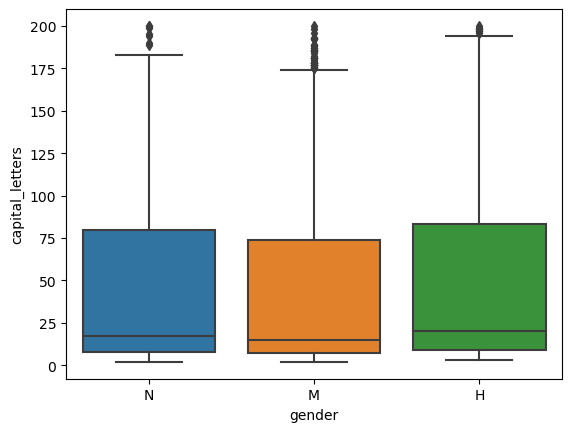

In [83]:
aux_analyze = analyze_df.copy()
remove_outliers(aux_analyze,'capital_letters',200)
sns.boxplot(x='gender',y='capital_letters',data=aux_analyze)

<Axes: xlabel='gender', ylabel='characters'>

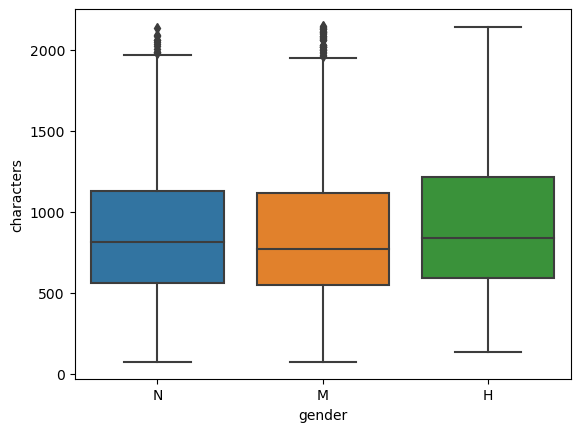

In [95]:
aux_analyze = analyze_df.copy()
remove_outliers(aux_analyze,'characters',2150)
sns.boxplot(x='gender',y='characters',data=aux_analyze)

<Axes: xlabel='gender', ylabel='punctuations'>

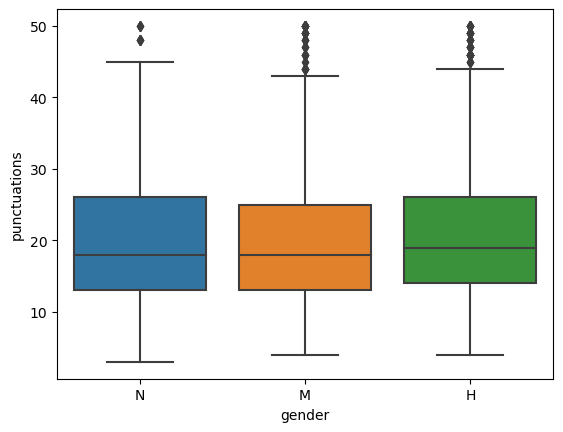

In [98]:
aux_analyze = analyze_df.copy()
remove_outliers(aux_analyze,'punctuations',50)
sns.boxplot(x='gender',y='punctuations',data=aux_analyze)

<Axes: xlabel='gender', ylabel='ratio_pre'>

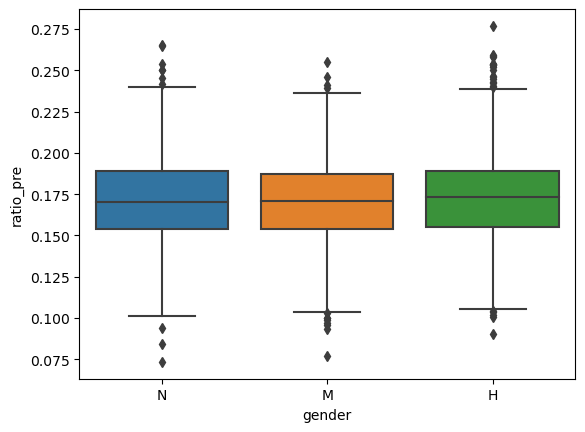

In [99]:
aux_analyze = analyze_df.copy()
#remove_outliers(aux_analyze,'ratio_pre',50)
sns.boxplot(x='gender',y='ratio_pre',data=aux_analyze)

<Axes: xlabel='gender', ylabel='ratio_adv'>

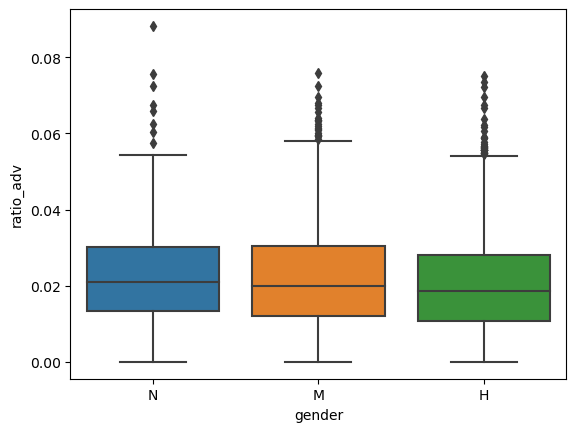

In [109]:
aux_analyze = analyze_df.copy()
#remove_outliers(aux_analyze,'ratio_pre',50)
sns.boxplot(x='gender',y='ratio_adv',data=aux_analyze)

<Axes: xlabel='gender', ylabel='ratio_pronouns'>

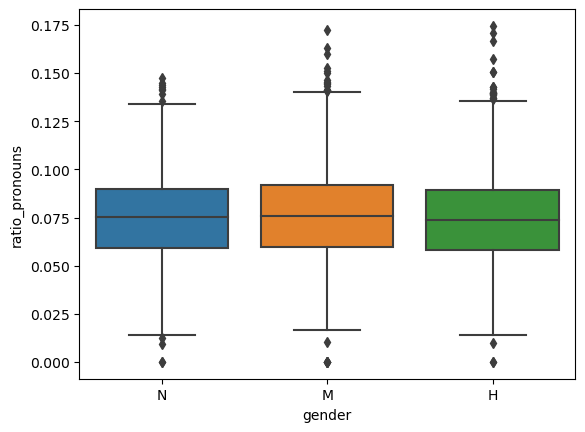

In [111]:
aux_analyze = analyze_df.copy()
#remove_outliers(aux_analyze,'ratio_pre',50)
sns.boxplot(x='gender',y='ratio_pronouns',data=aux_analyze)

<Axes: xlabel='gender', ylabel='num_unique'>

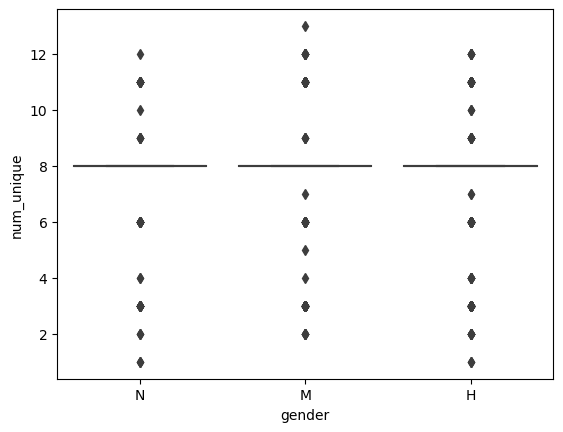

In [112]:
aux_analyze = analyze_df.copy()
#remove_outliers(aux_analyze,'ratio_pre',50)
sns.boxplot(x='gender',y='num_unique',data=aux_analyze)

<Axes: xlabel='gender', ylabel='av_length'>

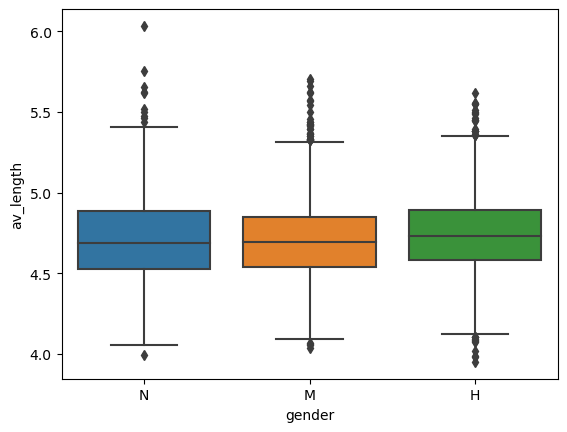

In [113]:
aux_analyze = analyze_df.copy()
#remove_outliers(aux_analyze,'ratio_pre',50)
sns.boxplot(x='gender',y='av_length',data=aux_analyze)

<Axes: xlabel='gender', ylabel='num_greater'>

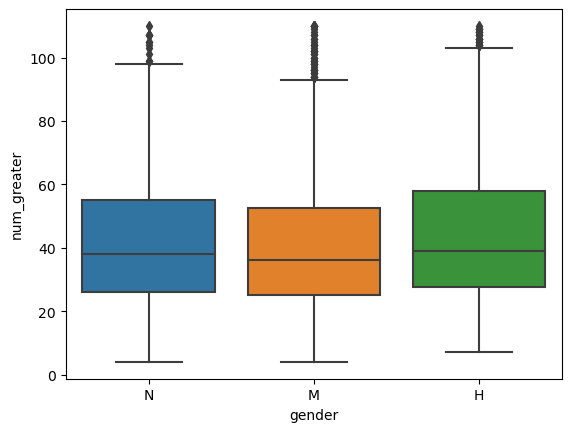

In [116]:
aux_analyze = analyze_df.copy()
remove_outliers(aux_analyze,'num_greater',110)
sns.boxplot(x='gender',y='num_greater',data=aux_analyze)

# Adversarial training

1. Create a substitute target model (logistic regression) and fit it with the data: the data will consist on the document vector, calculated as follows: 
    * word embeddings will be calculated using glove
    * using tfidf vectorizer, we will construct a matrix with the weights of each word
    * the document vector will be computed averaging the word embeddings with their corresponding weights

In [140]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker

In [141]:
spanish_dict = SpellChecker(language='es')

In [24]:
def load_embedding(file_path):
    embedding_vectors = {}
    with open(f'../../embeddings/{file_path}','r') as f:
        first_line = f.readline().split(' ')
        for line in f.readlines()[1:]:
            row = line.split(' ')
            word = row[0]
            if word not in embedding_vectors.keys():
                embedding_vectors[word] = [float(val) for val in row[1:]]
        
    return embedding_vectors

In [25]:
df_embedding = pd.DataFrame(columns=[str(i) for i in range(300)])
print('loading embedding')
embedding_vectors = load_embedding('glove-sbwc.i25.vec')
print('embedding loaded')

loading embedding
embedding loaded


In [288]:
vectorizer = TfidfVectorizer()

documents = []
documents_embeddings = []

i = 0
for file in files:
    with open(f'../Atestados/{file}') as f:
        print(f'{i+1} out of {len(files)}')
        _dict = json.load(f)

        # denuncia
        text = _dict['denuncia']
        text = quitar_tags(text)
        text = quitar_guiones(text)
        text = text.lower()
        text = remove_stopwords(text,stop_words)
        text = text.replace('\n',' ')
        cleaned_text = replace_multi_whitespaces(text)
        cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
        cleaned_text = cleaned_text.translate(str.maketrans('','',string.digits))

        document_vector = {}

        embedding_words = ""
        for token in set(word_tokenize(cleaned_text,language='spanish',preserve_line=True)):
                vector = embedding_vectors.get(token)
                if vector is not None:
                    document_vector[token] = vector
                    embedding_words += f'{token} '
                else:
                    corrected = spanish_dict.correction(token)
                    vector = embedding_vectors.get(corrected)
                    if vector is not None:
                        document_vector[corrected] = vector
                        embedding_words += f'{corrected} ' 
                     

        documents_embeddings.append(document_vector)

        documents.append(embedding_words[:-1])

        i += 1

# weights of words in each document
matrix = vectorizer.fit_transform(documents)
index_value={i[1]:i[0] for i in vectorizer.vocabulary_.items()}

# list of dictionaries: each dictionary represents a document, key := word in the document, value := weight of the word
fully_indexed = []
for row in matrix:
    fully_indexed.append({index_value[column]:value for (column,value) in zip(row.indices,row.data)})

1 out of 3707
2 out of 3707
3 out of 3707
4 out of 3707
5 out of 3707
6 out of 3707
7 out of 3707
8 out of 3707
9 out of 3707
10 out of 3707
11 out of 3707
12 out of 3707
13 out of 3707
14 out of 3707
15 out of 3707
16 out of 3707
17 out of 3707
18 out of 3707
19 out of 3707
20 out of 3707
21 out of 3707
22 out of 3707
23 out of 3707
24 out of 3707
25 out of 3707
26 out of 3707
27 out of 3707
28 out of 3707
29 out of 3707
30 out of 3707
31 out of 3707
32 out of 3707
33 out of 3707
34 out of 3707
35 out of 3707
36 out of 3707
37 out of 3707
38 out of 3707
39 out of 3707
40 out of 3707
41 out of 3707
42 out of 3707
43 out of 3707
44 out of 3707
45 out of 3707
46 out of 3707
47 out of 3707
48 out of 3707
49 out of 3707
50 out of 3707
51 out of 3707
52 out of 3707
53 out of 3707
54 out of 3707
55 out of 3707
56 out of 3707
57 out of 3707
58 out of 3707
59 out of 3707
60 out of 3707
61 out of 3707
62 out of 3707
63 out of 3707
64 out of 3707
65 out of 3707
66 out of 3707
67 out of 3707
68 o

In [88]:
fully_indexed[0]

{'comparece': 0.2387476967506432,
 'mercadona': 0.3205687883050859,
 'presenta': 0.2501762926150212,
 'abogado': 0.25706814084414775,
 'dia': 0.06569492204256404,
 'comercial': 0.1968679190961328,
 'calidad': 0.24841622072662295,
 'numero': 0.17801714732438564,
 'cuerpo': 0.3037433111769044,
 'manuscrita': 0.36334346474091467,
 'ocurrida': 0.1441311262561263,
 'colegiado': 0.44613330777885746,
 'establecimiento': 0.14313957361224325,
 'sustraccion': 0.14302390239086207,
 'presentes': 0.18335987547913726,
 'adjunta': 0.21723959935763043,
 'denuncia': 0.06574809537591793,
 'que': 0.07014843551083132}

In [289]:
# embedding df is computed by:
# each word in the document has an embedding and a weight (computed in the previous step)
# calculate document vector by computing the averaged weight vector of each word 

df_emb = pd.DataFrame(columns=[str(i) for i in range(300)])

for weight_dict, vector_dict in zip(fully_indexed,documents_embeddings):

    sum_array = np.zeros((1,300))
    sum_weights = 0

    for word, vector in vector_dict.items():
        weight = weight_dict.get(word)
        if weight is None:
            weight = 1

        sum_weights += weight
        weighted_array = [weight*value for value in vector]
        sum_array = np.add(sum_array,weighted_array)
    
    df_emb.loc[len(df_emb)] = [v/sum_weights for v in sum_array.tolist()[0]]

In [290]:
from sklearn.linear_model import LogisticRegression

df = df_emb.copy()

gender_map = {'M':0,'H':1}

df['file'] = files

X_train, X_test, y_train, y_test = train_test_split(df, denunciante_df['gender'].map(gender_map), stratify=denunciante_df['gender'], test_size=0.3,random_state=109)

test_files = X_test['file']
X_train.drop(['file'],axis=1,inplace=True)
X_test.drop(['file'],axis=1,inplace=True)

In [291]:
from sklearn.linear_model import LogisticRegression

df_policia = df_emb.copy()

gender_map = {'M':0,'H':1}

df_policia['file'] = files

X_train_policia, X_test_policia, y_train_policia, y_test_policia = train_test_split(df_policia, policia_df['gender'].map(gender_map), stratify=policia_df['gender'], test_size=0.3,random_state=109)

test_files = X_test_policia['file']
X_train_policia.drop(['file'],axis=1,inplace=True)
X_test_policia.drop(['file'],axis=1,inplace=True)

In [292]:
df_all = pd.concat([df_emb,analyze_df],axis=1)
df_all = df_all.iloc[:,~df_all.columns.duplicated()]

In [293]:
from sklearn.linear_model import LogisticRegression

df = df_all.copy()

gender_map = {'M':0,'H':1}

df['file'] = files

target = df['gender']
df.drop(['gender'],axis=1,inplace=True)

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df, target.map(gender_map), stratify=target, test_size=0.3,random_state=109)

test_files = X_test_all['file']
X_train_all.drop(['file'],axis=1,inplace=True)
X_test_all.drop(['file'],axis=1,inplace=True)

In [294]:
from sklearn.linear_model import LogisticRegression

df_policia = df_all.copy()

gender_map = {'M':0,'H':1}

df_policia['file'] = files

target = df_policia['gender']
df_policia.drop(['gender'],axis=1,inplace=True)

X_train_policia_all, X_test_policia_all, y_train_policia_all, y_test_policia_all = train_test_split(df_policia, target.map(gender_map), stratify=target, test_size=0.3,random_state=109)

test_files = X_test_policia_all['file']
X_train_policia_all.drop(['file'],axis=1,inplace=True)
X_test_policia_all.drop(['file'],axis=1,inplace=True)

In [85]:
def word_importance(clf,index,row):
    words = fully_indexed[index].keys()
    row_df = pd.DataFrame(columns=[str(i) for i in range(300)])
    row_df.loc[len(row_df)] = row[0]
    prob_original = clf.predict_proba(row_df)[0]
    predicted_val = int(clf.predict(row_df)[0])
    # O_y(D)
    logit_score_original = math.log(prob_original[predicted_val]/(1 - prob_original[predicted_val]))

    word_importance = {}

    for remove_word in words:
        sum_array = np.zeros((1,300))
        sum_weights = 0
        for word, weight in fully_indexed[index].items():
            if word != remove_word:
                sum_weights += weight
                vector = embedding_vectors.get(word)
                if vector is not None:
                    weighted_array = [weight*value for value in vector]
                    sum_array = np.add(sum_array,weighted_array)

        final_array = pd.DataFrame(columns=[str(i) for i in range(300)])
        final_array.loc[len(final_array)] = [v/sum_weights for v in sum_array.tolist()[0]]
        prob_removed = clf.predict_proba(final_array)[0]
        predicted_removed = int(clf.predict(final_array)[0])
        # O_y(D-removed)
        logit_score_removed = math.log(prob_removed[predicted_val]/(1 - prob_removed[predicted_val]))

        if predicted_val == predicted_removed:
            importance_score = logit_score_original - logit_score_removed
        else:
            logit_score_neg_original = math.log(prob_original[predicted_removed]/(1 - prob_original[predicted_removed]))
            logit_score_neg_removed = math.log(prob_removed[predicted_removed]/(1 - prob_removed[predicted_removed]))
            importance_score = logit_score_original - logit_score_removed + logit_score_neg_original - logit_score_neg_removed

        word_importance[remove_word] = importance_score
    
    return word_importance


In [86]:
def top_ranked(clf,index,document,max_value):
    importance = word_importance(clf,index,document)
    importance_sorted = {k: v for k, v in sorted(importance.items(), key=lambda item: item[1], reverse=True)[0:max_value]}
    return importance_sorted

In [34]:
# remove added accents
def normalize(s):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
        ("ü","u"),
        ("ñ","n"),
        ("ç","c"),
        ("\u2026","..."),
    )
    for a, b in replacements:
        s = s.replace(a, b).replace(a.upper(), b.upper())
    return s

## Similarity strategy
For each target word calculate possible replacing candidates: compute cosine similarity between candidate and original word, and only keep those candidates that meet a certain threshold, in our case > 0.7

In [32]:
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('../../embeddings/glove-sbwc.i25.vec')

In [287]:
def select_candidates(target_words):
    candidates_dict = {}
    for t in target_words:

        if t in w2v_model.key_to_index:
            res = [item[0] for item in w2v_model.most_similar(t, topn=len(w2v_model.key_to_index)) if item[1] > 0.65]
            candidates_dict[t] = res

    return candidates_dict

In [164]:
from nltk.corpus import wordnet as wn
from sklearn.metrics.pairwise import cosine_similarity

In [193]:
def select_synonims(target_words):
    
    candidates_dict = {}
    for t in target_words:
        candidates = []
        for sinonimos in wn.synonyms(t,'spa'):
            if len(sinonimos) > 0:
                for sin in sinonimos:
                    vec = embedding_vectors.get(sin)
                    if vec is not None:
                        cosine = cosine_similarity(np.asarray(embedding_vectors.get(t)).reshape(1,-1),np.asarray(vec).reshape(1,-1))[0][0]
                        if cosine > 0.65:
                            candidates.append(sin)
        
        if len(candidates) == 0:
            candidates = [item[0] for item in w2v_model.most_similar(t, topn=len(w2v_model.key_to_index)) if item[1] > 0.65]

        candidates_dict[t] = candidates

    return candidates_dict

## Checks
Check if candidates are of the same grammatical category: 
* In case they are verbs, check if the verb tense is the same
* In case they are nouns, check they have to be both singular or both plural
* In case they are adjectives, both have to be of the same gender and number

In [38]:
pos_tag = nltk.UnigramTagger(cess_esp.tagged_sents())

In [39]:
def check_gram_category(candidates):
    final_candidates = {}
    for t,c in candidates.items():
        target_tag = pos_tag.tag([t])[0][1]

        if target_tag is not None:
            final_candidates[t] = []
            candidates_tags = pos_tag.tag(c)

            for c in candidates_tags:
                c_tag = c[1]
                if c_tag is not None:
                    if target_tag[0] == c_tag[0]:

                        # si adjetivo
                        if target_tag[0] == 'a':
                            # mismo numero (sing o plural)
                            if target_tag[4] == c_tag[4]:
                                # si genero es masc
                                if target_tag[3] == 'm':
                                    if c_tag[3] == 'm' or c_tag[3] == 'c':
                                        final_candidates[t].append(c[0])
                                # si genero es fem
                                elif target_tag[3] == 'f':
                                    if c_tag[3] == 'f' or c_tag[3] == 'c':
                                        final_candidates[t].append(c[0])
                                # genero comun
                                else:
                                    final_candidates[t].append(c[0])
                    
                        # si sustantivo
                        if target_tag[0] == 'n':
                            # mismo numero (sing o plural)
                            if target_tag[3] == c_tag[3]:
                                final_candidates[t].append(c[0])
                        
                        # si verbo
                        if target_tag[0] == 'v':
                            if target_tag == c_tag:
                                final_candidates[t].append(c[0])

    return {key:val for key, val in final_candidates.items() if len(val)>0}

In [40]:
def combine(arrays,num_combinations):

    s0 = (1,) * len(arrays)
    output = [np.asanyarray(x).reshape(s0[:i] + (-1,) + s0[i + 1:])
              for i, x in enumerate(arrays)]

    output[0].shape = (1, -1) + s0[2:]
    output[1].shape = (-1, 1) + s0[2:]
    
    output = np.broadcast_arrays(*output, subok=True)

    return np.array(output).T.reshape(-1, num_combinations)

In [333]:
def cosine_similarity_sentences(results_diff_probabilities,results_targets,results_candidates,index):

    # get top 3 (most neutral) candidates
    if len(results_diff_probabilities) > 3:
        diff_prob_sorted = sorted(results_diff_probabilities)[0:3]
    else:
        diff_prob_sorted = sorted(results_diff_probabilities)

    # sentence cosine similarity
    indexes = [results_diff_probabilities.index(prob) for prob in diff_prob_sorted]
    top3_targets = [results_targets[idx] for idx in indexes]
    top3_candidates = [results_candidates[idx] for idx in indexes]

    file = test_files[index]

    cosine_similarity_dict = {}
    for targets, candidates in zip(top3_targets,top3_candidates):

        with open(f'../Atestados/{file}') as f:

            cosine_similarity_dict[targets] = []

            _dict = json.load(f)

            # denuncia
            text = _dict['denuncia']
            text = quitar_tags(text)
            text = quitar_guiones(text)
            text = text.lower()
            text = remove_stopwords(text,stop_words)
            cleaned_text = replace_multi_whitespaces(text)
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.punctuation))
            cleaned_text = cleaned_text.translate(str.maketrans('','',string.digits))

            sentences = cleaned_text.split('\n')

            replace = {}
            for t,c in zip(targets,candidates):
                replace[t] = c

            replace = dict((re.escape(k), v) for k, v in replace.items()) 
            pattern = re.compile("|".join(replace.keys()))

            for sent in sentences:
                replaced_vector = []
                sentence_vector = []

                words = set(word_tokenize(sent,language='spanish',preserve_line=True))

                # if sentence contains target word
                intersection = list(set(words) & set(targets))

                if len(intersection) > 0:
                    # two loops through the sentece, first to compute vector without replacing, second time replacing
                    for i in range(2):
                        if i == 1:
                            replaced_sent = pattern.sub(lambda m: replace[re.escape(m.group(0))], sent)
                            words = set(word_tokenize(replaced_sent,language='spanish',preserve_line=True))

                        for token in words:
                            vector = embedding_vectors.get(token)
                            if vector is not None:
                                if i == 1:
                                    replaced_vector.append(vector)
                                else:
                                    sentence_vector.append(vector)

                    
                    av_sentence_vector = np.asarray(sentence_vector).mean(0)
                    av_replaced_vector = np.asarray(replaced_vector).mean(0)

                    sent_cosine_sim = cosine_similarity(av_replaced_vector.reshape(1,-1),av_sentence_vector.reshape(1,-1))
                    cosine_similarity_dict[targets].append(sent_cosine_sim)

    if len(intersection) == 0:
        return top3_targets[0],1

    # compute the av of the cosine similarity of sentences for each possible replacement
    for k,v in cosine_similarity_dict.items():
        cosine_similarity_dict[k] = sum(v)/len(v)

    # best candidate is the one who has more similarity
    best_target = max(cosine_similarity_dict)
    best_cosine_sim = cosine_similarity_dict.get(best_target)

    return best_target, best_cosine_sim

In [316]:
from itertools import combinations

def substitute(clf,index,row,final_candidates,sf):
    results_targets = []
    results_candidates = []
    results_probabilities = []
    results_diff_probabilities = []

    if sf is not None:

        row_df = pd.DataFrame(columns=[str(i) for i in range(300)]+sf)
        row_df.loc[len(row_df)] = row.values.reshape(1,-1)[0]

        sf_data = list(row.drop([str(i) for i in range(300)]))
    
    else:
        row_df = pd.DataFrame(columns=[str(i) for i in range(300)])
        row_df.loc[len(row_df)] = row.values.reshape(1,-1)[0]


    if len(final_candidates.keys()) == 1:

        targ = list(final_candidates.keys())[0]
        cand = list(final_candidates.values())[0]

        for candidates in cand:
            sum_array = np.zeros((1,300))
            sum_weights = 0
            for word, weight in fully_indexed[index].items():
                # change candidate
                if word == targ:
                    word = candidates

                sum_weights += weight
                vector = embedding_vectors.get(word)
                if vector is not None:
                    weighted_array = [weight*value for value in vector]
                    sum_array = np.add(sum_array,weighted_array)

            if sf is not None: 
                replaced_array = pd.DataFrame(columns=[str(i) for i in range(300)] + sf)
                replaced_array.loc[len(replaced_array)] = [v/sum_weights for v in sum_array.tolist()[0]] + sf_data

            else:
                replaced_array = pd.DataFrame(columns=[str(i) for i in range(300)])
                replaced_array.loc[len(replaced_array)] = [v/sum_weights for v in sum_array.tolist()[0]]

            prob_replaced = clf.predict_proba(replaced_array)[0]

            results_targets.append(targ)
            results_candidates.append(candidates)
            results_diff_probabilities.append(abs(prob_replaced[0] - prob_replaced[1]))
            results_probabilities.append(prob_replaced)
        
        

    for num_combi in range(2,len(final_candidates.keys())+1):

        target_combis = list(combinations(final_candidates.keys(), num_combi))

        for target_words in target_combis:
            candidates = []
            for t in target_words:
                candidates.append(final_candidates.get(t))
            
            final = combine(candidates,num_combi)

            for candidates in final:
                sum_array = np.zeros((1,300))
                sum_weights = 0
                for word, weight in fully_indexed[index].items():
                    # change candidate
                    if word in target_words:
                        word = candidates[target_words.index(word)]

                    sum_weights += weight
                    vector = embedding_vectors.get(word)
                    if vector is not None:
                        weighted_array = [weight*value for value in vector]
                        sum_array = np.add(sum_array,weighted_array)

                if sf is not None: 
                    replaced_array = pd.DataFrame(columns=[str(i) for i in range(300)] + sf)
                    replaced_array.loc[len(replaced_array)] = [v/sum_weights for v in sum_array.tolist()[0]] + sf_data

                else:
                    replaced_array = pd.DataFrame(columns=[str(i) for i in range(300)])
                    replaced_array.loc[len(replaced_array)] = [v/sum_weights for v in sum_array.tolist()[0]]

                prob_replaced = clf.predict_proba(replaced_array)[0]

                results_targets.append(target_words)
                results_candidates.append(candidates)
                results_diff_probabilities.append(abs(prob_replaced[0] - prob_replaced[1]))
                results_probabilities.append(prob_replaced)

    best_target, best_cosine_sim = cosine_similarity_sentences(results_diff_probabilities,results_targets,results_candidates,index)
    best_candidate = results_candidates[results_targets.index(best_target)]
    best_prob = results_probabilities[results_targets.index(best_target)]
    original_prob = clf.predict_proba(row_df)[0]


    return best_candidate, best_target, best_prob, original_prob, best_cosine_sim

## DENUNCIANTE

In [51]:
i = 0

y_test = []
y_pred = []
differences_probabilities = []
num_replaced_neutral = 0
num_original_neutral = 0

for index, row in X_test.iterrows():
    #print(word_importance(index,row))
    target_words = top_ranked(index,row.to_numpy().reshape(1,300),20)
    target_words_correct = [corregir_acentos(w) for w in target_words]
    candidates_dict = select_candidates(target_words_correct)
    final_candidates = check_gram_category(candidates_dict)
    best_candidate, best_target, best_prob, original_prob = substitute(index,row,final_candidates)
    

    print('WORDS SUBSTITUTED:')
    print(best_target)
    print('FINAL SUBSTITUTION WORDS:')
    print(best_candidate)
    print('PREDICTED NEUTRALIZED PROBABILITIES')
    print(best_prob)
    print('PREDICTED ORIGINAL PROBABILITIES')
    print(original_prob)

    y_test.append(np.where(original_prob == max(original_prob))[0][0])
    y_pred.append(np.where(best_prob == max(best_prob))[0][0])

    differences_probabilities.append(abs(best_prob[0] - best_prob[1]))

    if abs(best_prob[0] - best_prob[1]) < 0.18:
        num_replaced_neutral += 1

    if abs(original_prob[0] - original_prob[1]) < 0.18:
        num_original_neutral += 1
    
    i += 1
    if i == 10:
        break

# calculate the average difference between the predicted probabilities
mean_diff_predicted_prob = sum(differences_probabilities) / len(differences_probabilities)
print(f'Mean differences in replaced predicted probabilities: {mean_diff_predicted_prob}')

# number of original neutral texts vs number of substituted neutral texts
# we consider a text to be neutral if the absolute difference between the model's predicted probabilities is less than 0.18
print(f'Number of original neutrals vs Number of replaced neutrals: {num_original_neutral} originals vs {num_replaced_neutral} replaced')

WORDS SUBSTITUTED:
('jurídico', 'relevante', 'ordenanza', 'ayuntamiento', 'representante')
FINAL SUBSTITUTION WORDS:
['legal' 'significativo' 'ley' 'consistorio' 'delegación']
PREDICTED NEUTRALIZED PROBABILITIES
[0.41212192 0.58787808]
PREDICTED ORIGINAL PROBABILITIES
[0.09510791 0.90489209]
WORDS SUBSTITUTED:
('izquierdo', 'día', 'hora')
FINAL SUBSTITUTION WORDS:
['lateral' 'motivo' 'momento']
PREDICTED NEUTRALIZED PROBABILITIES
[0.28724352 0.71275648]
PREDICTED ORIGINAL PROBABILITIES
[0.06064058 0.93935942]
WORDS SUBSTITUTED:
('aprecio', 'realiza', 'regresa')
FINAL SUBSTITUTION WORDS:
['afecto' 'desarrolla' 'vuelve']
PREDICTED NEUTRALIZED PROBABILITIES
[0.41492165 0.58507835]
PREDICTED ORIGINAL PROBABILITIES
[0.11934967 0.88065033]
WORDS SUBSTITUTED:
('aportar', 'ferrocarril')
FINAL SUBSTITUTION WORDS:
['proporcionar' 'tren']
PREDICTED NEUTRALIZED PROBABILITIES
[0.4817568 0.5182432]
PREDICTED ORIGINAL PROBABILITIES
[0.10972956 0.89027044]
WORDS SUBSTITUTED:
('encontraba', 'datos', 'h

## POLICIA

In [88]:
i = 0

y_test = []
y_pred = []
differences_probabilities = []
num_replaced_neutral = 0
num_original_neutral = 0

clf_policia = svm.SVC(C=10,gamma=1,kernel='rbf')
clf_policia.fit(X_train_policia,y_train_policia)

y_pred_policia = clf_policia.predict(X_test_policia)
acc_score = accuracy_score(y_test_policia,y_pred_policia)
print(acc_score)

for index, row in X_test_policia.iterrows():
    #print(word_importance(index,row))
    target_words = top_ranked(clf,index,row.to_numpy().reshape(1,300),20)
    target_words_correct = [if spanish_dict.correction(t) is not None else t spanish_dict.correction(t) for t in target_words]
    candidates_dict = select_candidates(target_words_correct)
    final_candidates = check_gram_category(candidates_dict)
    if len(final_candidates) == 0:
        continue
    
    best_candidate, best_target, best_prob, original_prob = substitute(clf_policia,index,row,final_candidates)
    

    print('WORDS SUBSTITUTED:')
    print(best_target)
    print('FINAL SUBSTITUTION WORDS:')
    print(best_candidate)
    print('PREDICTED NEUTRALIZED PROBABILITIES')
    print(best_prob)
    print('PREDICTED ORIGINAL PROBABILITIES')
    print(original_prob)

    y_test.append(np.where(original_prob == max(original_prob))[0][0])
    y_pred.append(np.where(best_prob == max(best_prob))[0][0])

    differences_probabilities.append(abs(best_prob[0] - best_prob[1]))

    if abs(best_prob[0] - best_prob[1]) < 0.18:
        num_replaced_neutral += 1

    if abs(original_prob[0] - original_prob[1]) < 0.18:
        num_original_neutral += 1
    
    i += 1
    if i == 10:
        break

# calculate the average difference between the predicted probabilities
mean_diff_predicted_prob = sum(differences_probabilities) / len(differences_probabilities)
print(f'Mean differences in replaced predicted probabilities: {mean_diff_predicted_prob}')

# number of original neutral texts vs number of substituted neutral texts
# we consider a text to be neutral if the absolute difference between the model's predicted probabilities is less than 0.18
print(f'Number of original neutrals vs Number of replaced neutrals: {num_original_neutral} originals vs {num_replaced_neutral} replaced')

0.5750224618149147
WORDS SUBSTITUTED:
('mercado', 'sufre', 'sistema', 'tarde')
FINAL SUBSTITUTION WORDS:
['sector' 'padece' 'funcionamiento' 'noche']
PREDICTED NEUTRALIZED PROBABILITIES
[0.57838476 0.42161524]
PREDICTED ORIGINAL PROBABILITIES
[0.07202206 0.92797794]
WORDS SUBSTITUTED:
('mujer', 'marido', 'momentos', 'encontraba')
FINAL SUBSTITUTION WORDS:
['hombre' 'hermano' 'tiempos' 'estaba']
PREDICTED NEUTRALIZED PROBABILITIES
[0.50016586 0.49983414]
PREDICTED ORIGINAL PROBABILITIES
[0.17004488 0.82995512]
WORDS SUBSTITUTED:
('día', 'lugar', 'denuncia')
FINAL SUBSTITUTION WORDS:
['lugar' 'vez' 'querella']
PREDICTED NEUTRALIZED PROBABILITIES
[0.4999806 0.5000194]
PREDICTED ORIGINAL PROBABILITIES
[0.06432564 0.93567436]
WORDS SUBSTITUTED:
('participa', 'jefe', 'equipo', 'consiguiendo', 'individuo', 'autor')
FINAL SUBSTITUTION WORDS:
['organiza' 'cargo' 'técnico' 'ganando' 'persona' 'autora']
PREDICTED NEUTRALIZED PROBABILITIES
[0.33049148 0.66950852]
PREDICTED ORIGINAL PROBABILITIES
[

In [101]:
i = 0

y_test = []
y_pred = []
differences_probabilities = []
num_replaced_neutral = 0
num_original_neutral = 0

clf_policia = svm.SVC(C=10,gamma=1,kernel='rbf')
clf_policia.fit(X_train_policia,y_train_policia)

y_pred_policia = clf_policia.predict(X_test_policia)
acc_score = accuracy_score(y_test_policia,y_pred_policia)
print(acc_score)

for index, row in X_test_policia.iloc[100:150].iterrows():
    #print(word_importance(index,row))
    target_words = top_ranked(clf,index,row.to_numpy().reshape(1,300),20)
    target_words_correct = [spanish_dict.correction(t) for t in target_words]
    candidates_dict = select_candidates(target_words_correct)
    final_candidates = check_gram_category(candidates_dict)
    best_candidate, best_target, best_prob, original_prob = substitute(clf,index,row,final_candidates,sf)
    

    print('WORDS SUBSTITUTED:')
    print(best_target)
    print('FINAL SUBSTITUTION WORDS:')
    print(best_candidate)
    print('PREDICTED NEUTRALIZED PROBABILITIES')
    print(best_prob)
    print('PREDICTED ORIGINAL PROBABILITIES')
    print(original_prob)

    y_test.append(np.where(original_prob == max(original_prob))[0][0])
    y_pred.append(np.where(best_prob == max(best_prob))[0][0])

    differences_probabilities.append(abs(best_prob[0] - best_prob[1]))

    if abs(best_prob[0] - best_prob[1]) < 0.18:
        num_replaced_neutral += 1

    if abs(original_prob[0] - original_prob[1]) < 0.18:
        num_original_neutral += 1
    
    i += 1
    if i == 10:
        break

# calculate the average difference between the predicted probabilities
mean_diff_predicted_prob = sum(differences_probabilities) / len(differences_probabilities)
print(f'Mean differences in replaced predicted probabilities: {mean_diff_predicted_prob}')

# number of original neutral texts vs number of substituted neutral texts
# we consider a text to be neutral if the absolute difference between the model's predicted probabilities is less than 0.18
print(f'Number of original neutrals vs Number of replaced neutrals: {num_original_neutral} originals vs {num_replaced_neutral} replaced')

0.5750224618149147
WORDS SUBSTITUTED:
('mercado', 'sufre', 'sistema', 'tarde')
FINAL SUBSTITUTION WORDS:
['sector' 'padece' 'funcionamiento' 'noche']
PREDICTED NEUTRALIZED PROBABILITIES
[0.57838476 0.42161524]
PREDICTED ORIGINAL PROBABILITIES
[0.07202206 0.92797794]
WORDS SUBSTITUTED:
('mujer', 'marido', 'momentos', 'horas', 'interior', 'encontraba')
FINAL SUBSTITUTION WORDS:
['niña' 'esposo' 'tiempos' 'días' 'exterior' 'estaba']
PREDICTED NEUTRALIZED PROBABILITIES
[0.65654754 0.34345246]
PREDICTED ORIGINAL PROBABILITIES
[0.17004488 0.82995512]
WORDS SUBSTITUTED:
('día', 'lugar', 'denuncia')
FINAL SUBSTITUTION WORDS:
['semana' 'puesto' 'queja']
PREDICTED NEUTRALIZED PROBABILITIES
[0.48038659 0.51961341]
PREDICTED ORIGINAL PROBABILITIES
[0.06432564 0.93567436]
WORDS SUBSTITUTED:
('participa', 'jefe', 'equipo', 'consiguiendo', 'individuo', 'autor')
FINAL SUBSTITUTION WORDS:
['realiza' 'comandante' 'técnico' 'logrando' 'sujeto' 'autora']
PREDICTED NEUTRALIZED PROBABILITIES
[0.27933031 0.7

In [242]:
import itertools

In [363]:
def debias(clf, X_train, X_test, y_train, y_test, sinonimos, emb_sf, sf):

    i = 0

    y_pred_replaced = []
    y_test_replaced = []
    differences_probabilities = []
    cosine_similarities = []
    num_replaced_neutral = 0
    num_original_neutral = 0

    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)
    acc_score = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred,average='weighted')


    for index, row in X_test[100:150].iterrows():

        if emb_sf:
            orig = pd.DataFrame(columns=[str(i) for i in range(300)] + sf)
            orig.loc[len(orig)] = row.values.reshape(1,-1)[0]
            row_emb = row.drop(sf)
        else:
            row_emb = row
            orig = pd.DataFrame(columns=[str(i) for i in range(300)])
            orig.loc[len(orig)] = row.values.reshape(1,-1)[0]
        
        orig_proba = clf.predict_proba(orig)[0]
        if abs(orig_proba[0] - orig_proba[1]) < 0.18:
            continue
        
        #print(word_importance(index,row))
        target_words = top_ranked(clf,index,row_emb.to_numpy().reshape(1,300),20)
        target_words_correct = [spanish_dict.correction(t) if spanish_dict.correction(t) is not None else t for t in target_words]
        if sinonimos:
            candidates_dict = select_synonims(target_words_correct)
        else:
            candidates_dict = select_candidates(target_words_correct)
        final_candidates = check_gram_category(candidates_dict)
        #final_candidates = dict(itertools.islice(final_candidates.items(), 5))
        if len(final_candidates) == 0:
            continue
        best_candidate, best_target, best_prob, original_prob, best_cosine_sim = substitute(clf,index,row,final_candidates,sf)

        
        cosine_similarities.append(best_cosine_sim)

        y_test_replaced.append(np.where(original_prob == max(original_prob))[0][0])
        y_pred_replaced.append(np.where(best_prob == max(best_prob))[0][0])

        differences_probabilities.append(abs(best_prob[0] - best_prob[1]))

        if abs(best_prob[0] - best_prob[1]) < 0.18:
            num_replaced_neutral += 1

        if abs(original_prob[0] - original_prob[1]) < 0.18:
            num_original_neutral += 1
        
        i += 1

        
        print(f'{i} out of 50 -> orig: {original_prob}; rep: {best_prob}')


    print(f'Original ACC: {acc_score}, Original F1-score: {f1}')
    
    # calculate the average difference between the predicted probabilities
    mean_diff_predicted_prob = sum(differences_probabilities) / len(differences_probabilities)
    print(f'Mean differences in replaced predicted probabilities: {mean_diff_predicted_prob}')
    print(f'Minimum difference in replaced predicted probabilities: {min(differences_probabilities)}')

    av_cosine_sim = sum(cosine_similarities) / len(cosine_similarities)
    print(f'Average cosine similarity between original sentences and replaced sentences: {av_cosine_sim[0][0]}')

    acc_score_rep = accuracy_score(y_test,y_pred_replaced)
    f1_rep = f1_score(y_test,y_pred_replaced,average='weighted')
    print(f'Replaced ACC: {acc_score_rep}, Replaced F1-score: {f1_rep}')

    # number of original neutral texts vs number of substituted neutral texts
    # we consider a text to be neutral if the absolute difference between the model's predicted probabilities is less than 0.18
    print(f'Number of original neutrals vs Number of replaced neutrals: {num_original_neutral} originals vs {num_replaced_neutral} replaced')

In [ ]:
# denunciante con sinonimos solo embeddings

clf = svm.SVC(C=10,gamma=1,kernel='rbf',probability=True)

debias(clf, X_train, X_test, y_train, y_test, sinonimos = True, emb_sf = False, sf = None)

In [ ]:
# denunciante sin sinonimos (buscando en todo el diccionario) solo embeddings

clf = svm.SVC(C=10,gamma=1,kernel='rbf',probability=True)

debias(clf, X_train, X_test, y_train, y_test, sinonimos = False, emb_sf = False, sf = None)

In [ ]:
# denunciante sin sinonimos (buscando en todo el diccionario) embeddings + SF

clf = svm.SVC(C=10,gamma=1,kernel='rbf',probability=True)

debias(clf, X_train_all, X_test_all, y_train_all, y_test_all, sinonimos = True, emb_sf = True, sf = ['characters','capital_letters','punctuations','ratio_pre','ratio_adv','ratio_prop','ratio_pronouns','num_unique','av_length','num_greater'])

In [ ]:
# policia con sinonimos solo embeddings

clf = svm.SVC(C=10,gamma=1,kernel='rbf',probability=True)

debias(clf, X_train_policia, X_test_policia, y_train_policia, y_test_policia, sinonimos = True, emb_sf = False, sf = None)

In [ ]:
# policia sin sinonimos solo embeddings

clf = svm.SVC(C=10,gamma=1,kernel='rbf',probability=True)

debias(clf, X_train_policia, X_test_policia, y_train_policia, y_test_policia, sinonimos = False, emb_sf = False, sf = None)